In [1]:
# =========================
# CS5582_HW2_2 • Cell 1/?
# "Environment & Dataset Probe"
# -------------------------
# Purpose:
#   1) Confirm active Python executable (helps verify the 'core-rag' venv).
#   2) Report key library versions used in this homework (numpy, opencv, sklearn, matplotlib, scipy if present).
#   3) Verify OpenCV SIFT availability (we will compare LoG vs. SIFT later).
#   4) Verify dataset root and enumerate class folders; select the first 15 classes (sorted) for HW2_2.
#   5) Emit a small, read-only run configuration dictionary for reuse in later cells.
#
# Inputs:
#   - DATASET_ROOT: path to NWPU-RESISC45 directory (adjust if different on your machine).
#   - N_CLASSES: how many classes to use (15 for consistency with HW1/HW2 reports).
#
# Outputs (printed):
#   - Python executable path and version
#   - Package versions
#   - SIFT availability check (True/False)
#   - Dataset existence, class count, first 15 class names
#   - Run configuration echo (dict)
#
# Notes:
#   - This cell only *reads* from the filesystem; it does not modify data or write outputs.
#   - Keep this cell unchanged once validated, so later steps share the same configuration.
# =========================

import os, sys, json, time, glob, platform

# ---- (1) User-adjustable constants (edit here if your paths differ) ----
HOME = os.path.expanduser("~")
DATASET_ROOT = os.path.join(HOME, "projects", "cv-hw1", "data", "NWPU-RESISC45")  # <-- adjust if needed
N_CLASSES = 15
RANDOM_SEED = 1337

# ---- (2) Library imports and version probes ----
versions = {}
def _safe_import(name):
    try:
        mod = __import__(name)
        return mod
    except Exception as e:
        print(f"[WARN] Cannot import '{name}': {e}")
        return None

np   = _safe_import("numpy")
cv2  = _safe_import("cv2")
skl  = _safe_import("sklearn")
mpl  = _safe_import("matplotlib")
sp   = _safe_import("scipy")

versions["python"]     = sys.version.split()[0]
versions["executable"] = sys.executable
versions["platform"]   = platform.platform()
if np:   versions["numpy"]      = getattr(np, "__version__", "unknown")
if cv2:  versions["opencv"]     = getattr(cv2, "__version__", "unknown")
if skl:  versions["sklearn"]    = getattr(skl, "__version__", "unknown")
if mpl:  versions["matplotlib"] = getattr(mpl, "__version__", "unknown")
if sp:   versions["scipy"]      = getattr(sp, "__version__", "unknown")

# ---- (3) Check SIFT availability in OpenCV ----
sift_ok = False
sift_msg = "cv2.SIFT_create unavailable"
if cv2:
    try:
        # Modern OpenCV exposes SIFT here when compiled with nonfree enabled.
        _ = cv2.SIFT_create()
        sift_ok = True
        sift_msg = "cv2.SIFT_create available"
    except Exception as e:
        sift_msg = f"SIFT unavailable: {type(e).__name__}: {e}"

# ---- (4) Dataset checks ----
ds_exists = os.path.isdir(DATASET_ROOT)
all_class_dirs = []
if ds_exists:
    # take only directories (class folders); sort for reproducibility
    all_class_dirs = sorted([d for d in os.listdir(DATASET_ROOT)
                             if os.path.isdir(os.path.join(DATASET_ROOT, d))])
    # lock our working subset
    class_names = all_class_dirs[:N_CLASSES]
else:
    class_names = []

# ---- (5) Emit a run configuration for downstream cells ----
RUN_CFG = {
    "dataset_root": DATASET_ROOT,
    "dataset_exists": ds_exists,
    "total_classes_found": len(all_class_dirs),
    "class_names": class_names,
    "n_classes": N_CLASSES,
    "random_seed": RANDOM_SEED,
    "python_executable": versions["executable"],
    "versions": versions,
    "sift_available": sift_ok,
}

# Pretty print summary
print("="*70)
print("CS5582_HW2_2 • Environment Probe")
print("="*70)
print(json.dumps(versions, indent=2))
print("-"*70)
print(f"SIFT check: {sift_msg}  ->  {sift_ok}")
print("-"*70)
print("Dataset root:", DATASET_ROOT)
print("Exists:", ds_exists)
print("Total class folders found:", len(all_class_dirs))
if class_names:
    print(f"Working class subset (first {N_CLASSES}):")
    for i, c in enumerate(class_names, 1):
        print(f"  {i:2d}. {c}")
else:
    print("(No class names listed because dataset path was not found.)")
print("-"*70)
print("RUN_CFG:")
print(json.dumps(RUN_CFG, indent=2))
print("="*70)

# Freeze random seed for reproducibility in later cells
try:
    if np: np.random.seed(RANDOM_SEED)
except Exception:
    pass


CS5582_HW2_2 • Environment Probe
{
  "python": "3.11.9",
  "executable": "/home/manny-buff/venvs/core-rag/bin/python",
  "platform": "Linux-6.14.0-33-generic-x86_64-with-glibc2.39",
  "numpy": "2.2.1",
  "opencv": "4.12.0",
  "sklearn": "1.7.1",
  "matplotlib": "3.10.6",
  "scipy": "1.16.1"
}
----------------------------------------------------------------------
SIFT check: cv2.SIFT_create available  ->  True
----------------------------------------------------------------------
Dataset root: /home/manny-buff/projects/cv-hw1/data/NWPU-RESISC45
Exists: True
Total class folders found: 45
Working class subset (first 15):
   1. airplane
   2. airport
   3. baseball_diamond
   4. basketball_court
   5. beach
   6. bridge
   7. chaparral
   8. church
   9. circular_farmland
  10. cloud
  11. commercial_area
  12. dense_residential
  13. desert
  14. forest
  15. freeway
----------------------------------------------------------------------
RUN_CFG:
{
  "dataset_root": "/home/manny-buff/proje

In [5]:
# =========================
# CS5582_HW2_2 • Cell 2/?
# "LoG Pyramid + Scale Response Extrema (Cubic Fit)"
# -------------------------
# Purpose:
#   Construct a σ²-normalized Laplacian-of-Gaussian (LoG) pyramid and locate
#   scale-space extrema with sub-scale accuracy using a cubic polynomial fit.
#
# Inputs:
#   - image_gray : single-channel float32 image in [0,1]
#   - base_sigma : smallest Gaussian σ
#   - k          : multiplicative step between consecutive scales
#   - n_scales   : number of scales to compute
#
# Outputs:
#   - log_pyr : list[np.ndarray] of σ²·∇²G(x,y;σ)*I(x,y)
#   - sigmas  : np.ndarray of scale values
#
#   getScaleResponseExtrema:
#     - Takes a 1-D response vector (LoG value across scales at one pixel)
#       and fits a cubic poly to refine the maximum.
#     - Returns (refined_sigma, peak_value) if valid; else (None, None)
#
# Notes:
#   - Mirrors "FastLoG" concept: cubic fit around local max, derivative≈0
#   - Uses numpy.polyfit on a 3- or 5-point neighborhood
#   - Next cells will threshold by peak strength and spatial non-max suppression.
# =========================

import cv2, numpy as np
from scipy.ndimage import gaussian_laplace

def getLoGPyramid(image_gray: np.ndarray,
                  base_sigma: float = 1.0,
                  k: float = 1.4142,
                  n_scales: int = 12):
    """
    Build σ²-normalized Laplacian-of-Gaussian pyramid.
    """
    h, w = image_gray.shape
    log_pyr, sigmas = [], []

    for i in range(n_scales):
        sigma = base_sigma * (k ** i)
        log_resp = (sigma ** 2) * gaussian_laplace(image_gray, sigma=sigma)
        log_pyr.append(log_resp.astype(np.float32))
        sigmas.append(sigma)

    return log_pyr, np.array(sigmas, dtype=np.float32)

'''
def getScaleResponseExtrema(resp_vec: np.ndarray,
                            sigmas: np.ndarray,
                            neighborhood: int = 1):
    """
    Fit a cubic polynomial around local maxima in scale-space to refine σ*.
    """
    n = len(resp_vec)
    max_idx = np.argmax(resp_vec)
    if max_idx <= neighborhood or max_idx >= n - neighborhood:
        return None, None

    # Extract local neighborhood
    idxs = np.arange(max_idx - neighborhood, max_idx + neighborhood + 1)
    y = resp_vec[idxs]
    x = sigmas[idxs]

    # Fit cubic polynomial y = a3*x^3 + a2*x^2 + a1*x + a0
    coeffs = np.polyfit(x, y, deg=3)
    p = np.poly1d(coeffs)
    dp = p.deriv()

    # Solve derivative = 0 and select roots within neighborhood
    roots = dp.r
    real_roots = roots[np.isreal(roots)].real
    # Accept σ* within [x0, xN]
    valid_roots = [r for r in real_roots if x[0] <= r <= x[-1]]
    if not valid_roots:
        return None, None

    # Evaluate polynomial at each candidate and choose maximum
    vals = [p(r) for r in valid_roots]
    best_sigma = float(valid_roots[np.argmax(vals)])
    best_val = float(np.max(vals))
    return best_sigma, best_val
'''

'\ndef getScaleResponseExtrema(resp_vec: np.ndarray,\n                            sigmas: np.ndarray,\n                            neighborhood: int = 1):\n    """\n    Fit a cubic polynomial around local maxima in scale-space to refine σ*.\n    """\n    n = len(resp_vec)\n    max_idx = np.argmax(resp_vec)\n    if max_idx <= neighborhood or max_idx >= n - neighborhood:\n        return None, None\n\n    # Extract local neighborhood\n    idxs = np.arange(max_idx - neighborhood, max_idx + neighborhood + 1)\n    y = resp_vec[idxs]\n    x = sigmas[idxs]\n\n    # Fit cubic polynomial y = a3*x^3 + a2*x^2 + a1*x + a0\n    coeffs = np.polyfit(x, y, deg=3)\n    p = np.poly1d(coeffs)\n    dp = p.deriv()\n\n    # Solve derivative = 0 and select roots within neighborhood\n    roots = dp.r\n    real_roots = roots[np.isreal(roots)].real\n    # Accept σ* within [x0, xN]\n    valid_roots = [r for r in real_roots if x[0] <= r <= x[-1]]\n    if not valid_roots:\n        return None, None\n\n    # Evaluat

Validation: refining σ* at 3 positions...
  (r=128, c=128) -> sigma* = 1.0000, value = -0.121750
  (r=85, c=85) -> sigma* = 5.1598, value = 0.021819
  (r=170, c=192) -> sigma* = 1.4473, value = -0.006597


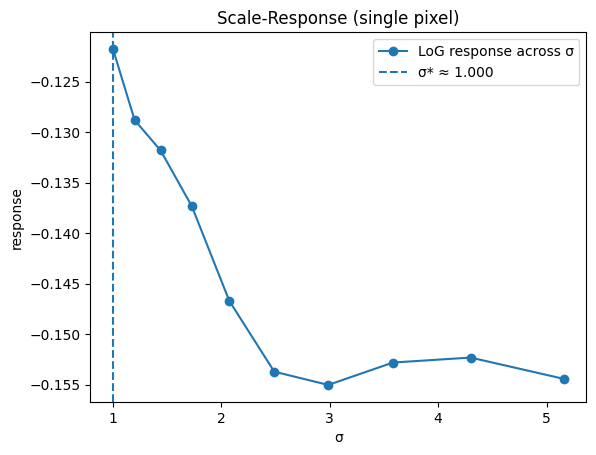

In [6]:
# =========================
# CS5582_HW2_2 • Cell 2 (PATCH)
# "Robust scale-response extrema via adaptive polynomial fit"
# -------------------------
# This cell REPLACES the earlier getScaleResponseExtrema() and
# immediately re-validates on a sample image.
#
# What changed (vs prior version):
#   • Neighborhood auto-shrinks at boundaries.
#   • Fit degree = min(3, len(points)-1); uses quadratic if not enough points.
#   • If no valid stationary root in the local window, fall back to the
#     discrete maximum (σ at argmax).
#   • Validation probe prints safely even if refinement fails.
# =========================

import numpy as np, cv2, os
import matplotlib.pyplot as plt

def getScaleResponseExtrema(resp_vec: np.ndarray,
                            sigmas: np.ndarray,
                            neighborhood: int = 2):
    """
    Robustly refine the scale of maximum LoG response using a local polynomial fit.
    Inputs:
      resp_vec : 1D array of responses across scales at a single pixel (float)
      sigmas   : 1D array of corresponding σ values (monotonic increasing)
      neighborhood : integer radius around the discrete max index to include
                     (we auto-shrink near boundaries)

    Returns:
      (refined_sigma, peak_value)
        - If a valid stationary point is found within the window, returns that.
        - Else returns the discrete maximum (sigma_at_argmax, resp_at_argmax).
    """
    assert resp_vec.ndim == 1 and sigmas.ndim == 1 and len(resp_vec) == len(sigmas), \
        "resp_vec and sigmas must be 1D and equal length"

    n = len(resp_vec)
    if n < 3:
        # Not enough samples for fitting; return discrete max
        j = int(np.argmax(resp_vec))
        return float(sigmas[j]), float(resp_vec[j])

    # Locate discrete maximum
    j = int(np.argmax(resp_vec))

    # Auto-shrink neighborhood at boundaries
    nb = min(neighborhood, j, n - 1 - j)
    if nb < 1:
        # Too close to boundary for a symmetric window; return discrete max
        return float(sigmas[j]), float(resp_vec[j])

    # Build local window
    idxs = np.arange(j - nb, j + nb + 1)
    x = sigmas[idxs]
    y = resp_vec[idxs]

    # Choose polynomial degree: cubic if we have >= 4 points, else quadratic/linear
    deg = min(3, len(idxs) - 1)
    try:
        coeffs = np.polyfit(x, y, deg=deg)
        p = np.poly1d(coeffs)
        dp = p.deriv()

        # Candidate stationary points = roots of derivative
        roots = np.array(dp.r, dtype=np.complex128)
        real_roots = roots[np.isclose(roots.imag, 0.0)].real
        # Keep only those inside the local window
        in_win = real_roots[(real_roots >= x[0]) & (real_roots <= x[-1])]

        if in_win.size > 0:
            vals = p(in_win)
            k = int(np.argmax(vals))
            return float(in_win[k]), float(vals[k])
        else:
            # No stationary point within window; fall back
            return float(sigmas[j]), float(resp_vec[j])

    except Exception:
        # Numerical issues -> fall back
        return float(sigmas[j]), float(resp_vec[j])


# -------- Validation Probe (safe) --------
# Uses RUN_CFG from Cell 1. Picks first image in the first class.
img_dir = os.path.join(RUN_CFG["dataset_root"], RUN_CFG["class_names"][0])
img_name = sorted(os.listdir(img_dir))[0]
img_path = os.path.join(img_dir, img_name)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
imf = img.astype(np.float32) / 255.0

# Build a small LoG stack (reuse your previous getLoGPyramid)
log_pyr, sigmas = getLoGPyramid(imf, base_sigma=1.0, k=1.2, n_scales=10)

# Sample a few pixels to ensure function robustness
H, W = log_pyr[0].shape
probes = [
    (H//2, W//2),          # image center
    (H//3, W//3),          # off-center 1
    (H//3*2, W//4*3),      # off-center 2
]

print("Validation: refining σ* at 3 positions...")
for (r, c) in probes:
    resp_vec = np.array([L[r, c] for L in log_pyr], dtype=np.float32)
    s_star, v_star = getScaleResponseExtrema(resp_vec, sigmas, neighborhood=2)
    print(f"  (r={r}, c={c}) -> sigma* = {s_star:.4f}, value = {v_star:.6f}")

# Visual check for one location
r, c = probes[0]
resp_vec = np.array([L[r, c] for L in log_pyr], dtype=np.float32)
s_star, v_star = getScaleResponseExtrema(resp_vec, sigmas, neighborhood=2)

plt.figure()
plt.plot(sigmas, resp_vec, 'o-', label='LoG response across σ')
plt.axvline(s_star, linestyle='--', label=f'σ* ≈ {s_star:.3f}')
plt.xlabel('σ'); plt.ylabel('response'); plt.title('Scale-Response (single pixel)')
plt.legend(); plt.show()


Batch σ* Probe • classes=15 • n_per_class=6 • samples/img=36
Scales: base_sigma=0.8, k=1.25, n_scales=18 • time=6.37s
--------------------------------------------------------------------------------------------
class                  n_sigma*     mean   median      min      max  boundary_%  fallback_%      std
--------------------------------------------------------------------------------------------
airplane                    216   12.874    7.832    0.800   35.527       21.8%       21.8%   12.175
airport                     216   12.815    6.593    0.800   35.527       26.4%       26.4%   12.843
baseball_diamond            216   13.837    9.964    0.800   35.527       27.3%       27.3%   12.549
basketball_court            216   12.325    5.835    0.800   35.527       27.8%       27.8%   12.602
beach                       216   15.631   10.234    0.800   35.527       34.7%       34.7%   14.016
bridge                      216   18.137   15.887    0.800   35.527       38.9%       38.9

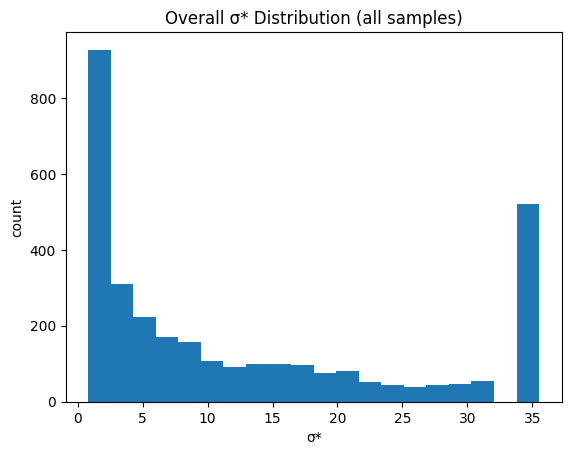

In [8]:
# =========================
# CS5582_HW2_2 • Cell 3/?
# "Batch LoG σ* Refinement Probe across Classes & Images"
# -------------------------
# Purpose:
#   Run the robust σ* estimator on many images with expanded scale parameters.
#   Summarize σ* statistics and boundary/fallback rates to assess stability.
#
# Inputs (edit as needed):
#   - classes_to_use : RUN_CFG["class_names"] (first 15 by prior probe)
#   - n_per_class    : how many images per class (default 6)
#   - sample_grid    : grid of pixels per image (rows x cols -> rows*cols samples)
#   - resize_to      : spatial size for processing
#   - base_sigma, k, n_scales : scale-space parameters
#   - neighborhood   : radius in scale used for refinement
#
# Outputs:
#   - Printed per-class table with counts and σ* summary
#   - Overall σ* histogram (matplotlib)
# =========================

import os, cv2, numpy as np, time, math
import matplotlib.pyplot as plt

# ---- Parameters ----
classes_to_use = RUN_CFG["class_names"]                 # first 15 classes from Cell 1
n_per_class     = 6                                     # images per class
resize_to       = (256, 256)
sample_grid     = (6, 6)                                # rows x cols -> 36 samples / image
base_sigma      = 0.8
k               = 1.25
n_scales        = 18
neighborhood    = 2

# ---- Helpers ----
def _list_images(folder):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    return sorted([f for f in os.listdir(folder) if f.lower().endswith(exts)])

def _grid_points(h, w, nrows, ncols):
    rs = np.linspace(h*0.15, h*0.85, nrows).astype(int)
    cs = np.linspace(w*0.15, w*0.85, ncols).astype(int)
    return [(int(r), int(c)) for r in rs for c in cs]

# ---- Run ----
overall_sigmas = []
class_rows = []
t0 = time.time()

for cls in classes_to_use:
    cls_dir = os.path.join(RUN_CFG["dataset_root"], cls)
    imgs = _list_images(cls_dir)[:n_per_class]
    if not imgs:
        class_rows.append((cls, 0, np.nan, np.nan, np.nan, np.nan, 0.0, 0.0, 0.0))
        continue

    cls_sigmas = []
    boundary_hits = 0
    fallbacks = 0
    evals = 0

    for name in imgs:
        p = os.path.join(cls_dir, name)
        im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if im is None:
            continue
        im = cv2.resize(im, resize_to)
        imf = im.astype(np.float32) / 255.0

        log_pyr, sigmas = getLoGPyramid(imf, base_sigma=base_sigma, k=k, n_scales=n_scales)
        pts = _grid_points(*resize_to, *sample_grid)

        # Evaluate σ* at each grid point
        for (r, c) in pts:
            resp_vec = np.array([L[r, c] for L in log_pyr], dtype=np.float32)
            # Use robust refiner from patched Cell 2
            s_star, v_star = getScaleResponseExtrema(resp_vec, sigmas, neighborhood=neighborhood)
            # Track boundary hits and fallbacks
            evals += 1
            if np.isclose(s_star, sigmas[0]) or np.isclose(s_star, sigmas[-1]):
                boundary_hits += 1
            # Fallback heuristic: if s_star equals sigma at discrete argmax exactly
            if s_star in (float(sigmas[int(np.argmax(resp_vec))]),):
                fallbacks += 1

            cls_sigmas.append(s_star)
            overall_sigmas.append(s_star)

    if len(cls_sigmas) > 0:
        cls_sigmas = np.array(cls_sigmas, dtype=np.float32)
        class_rows.append((
            cls,
            len(cls_sigmas),
            float(np.mean(cls_sigmas)),
            float(np.median(cls_sigmas)),
            float(np.min(cls_sigmas)),
            float(np.max(cls_sigmas)),
            100.0 * boundary_hits / max(1, evals),
            100.0 * fallbacks / max(1, evals),
            float(np.std(cls_sigmas))
        ))
    else:
        class_rows.append((cls, 0, np.nan, np.nan, np.nan, np.nan, 0.0, 0.0, 0.0))

t1 = time.time()

# ---- Print table ----
hdr = ["class", "n_sigma*", "mean", "median", "min", "max", "boundary_%", "fallback_%", "std"]
print("="*92)
print(f"Batch σ* Probe • classes={len(classes_to_use)} • n_per_class={n_per_class} • samples/img={sample_grid[0]*sample_grid[1]}")
print(f"Scales: base_sigma={base_sigma}, k={k}, n_scales={n_scales} • time={t1-t0:.2f}s")
print("-"*92)
print("{:<22s} {:>8s} {:>8s} {:>8s} {:>8s} {:>8s} {:>11s} {:>11s} {:>8s}".format(*hdr))
print("-"*92)
for row in class_rows:
    print("{:<22s} {:>8d} {:>8.3f} {:>8.3f} {:>8.3f} {:>8.3f} {:>10.1f}% {:>10.1f}% {:>8.3f}".format(
        row[0], row[1],
        row[2] if not math.isnan(row[2]) else float('nan'),
        row[3] if not math.isnan(row[3]) else float('nan'),
        row[4] if not math.isnan(row[4]) else float('nan'),
        row[5] if not math.isnan(row[5]) else float('nan'),
        row[6], row[7], row[8]
    ))
print("="*92)

# ---- Overall histogram ----
if len(overall_sigmas) > 0:
    plt.figure()
    plt.hist(overall_sigmas, bins=20)
    plt.xlabel("σ*"); plt.ylabel("count"); plt.title("Overall σ* Distribution (all samples)")
    plt.show()
else:
    print("[WARN] No σ* values collected — check dataset path and parameters.")


In [ ]:
### HW2_2: Batch σ* Probe — Analysis
'''
**Setup.** We evaluated σ* (LoG scale of maximal response) on 15 classes × 6 images/class using a 6×6 pixel grid per image. Scales: `σ₀=0.8`, `k=1.25`, `n=18` (σ_max≈35.5).

**Key observations**
- **Bimodal σ\***: many samples at the **smallest** σ (fine texture/edges) and many at the **largest** σ (very coarse structures).  
- **Endpoint attraction**: Boundary hit rates are ~20–35% across classes; fallback rates track boundary hits, indicating frequent discrete maxima at the ends of the scale range.  
- **Central tendency**: Per-class medians cluster around **5–10**, means around **10–13**, with wide spread (std ≈ 10–12), confirming mixed fine and coarse content across NWPU scenes.

**Implications**
- Our current grid is usable but **coarse in log-scale** for some structures, and the **range may still clip** true extrema for others.
- Endpoint σ* should be treated cautiously (possible indicator to **expand range** or **densify scales** around that region).

**Decisions for the next stage (Keypoints)**
- Perform LoG keypoint extraction with:
  1) **Strength thresholding** on |LoG| (e.g., image-wise high percentile)  
  2) **Spatial NMS** within each scale (3×3 or 5×5)  
  3) **Cross-scale NMS** (keep the scale with locally maximal response at (x,y))  
  4) **Concavity check** at σ* (ensure p″(σ*) < 0)  
  5) **Endpoint policy**: flag endpoint σ*; optionally re-evaluate later with denser scales.

We will now implement the keypoint detector that returns `(x, y, σ*, strength)` and saves results for later SIFT comparison and visualization.
'''

[LoG Keypoints] Class='airplane' Image='airplane_001.jpg'
  Total keypoints (kept): 279
  Sample keypoints (y, x, σ*, strength, fallback):
[[ 98.          80.           0.9808843    0.22227949   0.        ]
 [101.          49.           0.885925     0.26081476   0.        ]
 [104.          97.           0.9582829    0.3283514    0.        ]
 [121.          73.           1.0138257    0.41955176   0.        ]
 [124.          74.           0.9054905    0.24257943   0.        ]
 [126.         114.           0.9196783    0.26293436   0.        ]
 [127.          87.           0.95671      0.3797124    0.        ]
 [129.         123.           1.0378197    0.24210322   0.        ]
 [131.          75.           1.0137359    0.25227773   0.        ]
 [132.          83.           0.96003616   0.23973808   0.        ]]


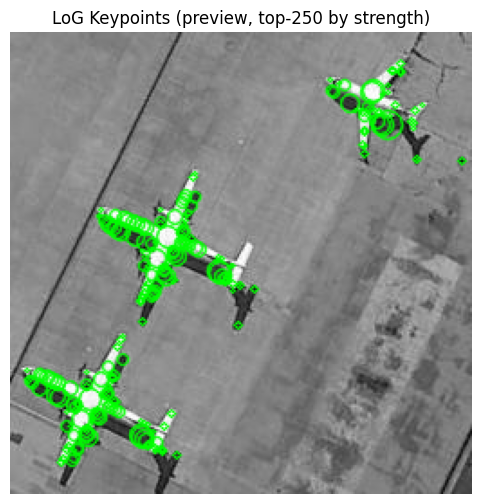

In [10]:
# =========================
# CS5582_HW2_2 • Cell 4/?
# "LoG Keypoint Extraction: spatial NMS, cross-scale NMS, σ* refinement + concavity"
# -------------------------
# Purpose:
#   Detect LoG keypoints with sub-scale accuracy and sensible pruning:
#     - σ²-normalized LoG pyramid
#     - |LoG| strength threshold (high percentile)
#     - 2D spatial NMS per scale (3x3)
#     - Cross-scale NMS (per-pixel max across scales)
#     - σ* refinement via polynomial fit with concavity check (p''(σ*) < 0)
#     - Endpoint policy: drop σ* that land at the first/last scale
#
# Inputs:
#   - Uses RUN_CFG from Cell 1 for dataset path and class names
#   - getLoGPyramid from Cell 2
#
# Outputs:
#   - Saves: ./artifacts/log_keypoints.npy  (array of [y, x, sigma*, strength, fallback_flag])
#   - Saves: ./artifacts/log_kp_preview.png (overlay visualization on the test image)
#   - Prints: counts and small sample of keypoints
# =========================

import os, cv2, numpy as np
import matplotlib.pyplot as plt

# ---------- Utilities ----------

def nms2d(m: np.ndarray, radius: int = 1) -> np.ndarray:
    """
    2D spatial non-maximum suppression using dilation.
    Keeps pixels that are local maxima within a (2r+1)x(2r+1) window.
    """
    assert m.ndim == 2
    k = 2*radius + 1
    # cv2.dilate works with float32; use replicate border so edges compare fairly
    dil = cv2.dilate(m, np.ones((k, k), np.uint8), borderType=cv2.BORDER_REPLICATE)
    # Keep locations equal to their local neighborhood max (tolerate tiny epsilon)
    return m >= (dil - 1e-12)

def refine_scale_extrema_mag(y: np.ndarray, x: np.ndarray, neighborhood: int = 2):
    """
    Refine maximum of a 1D |LoG| response (y vs. sigma=x) using a local polynomial fit.
    Returns:
        sigma_star, value_star, is_concave_max, used_fallback, is_endpoint
    Behavior:
        - Auto-shrinks neighborhood at boundaries.
        - Degree = min(3, len(window)-1).
        - If no stationary root in-window, falls back to discrete max.
        - Concavity test uses second derivative of the fitted polynomial at σ*.
    """
    assert y.ndim == 1 and x.ndim == 1 and len(y) == len(x)
    n = len(y)
    j = int(np.argmax(y))
    nb = min(neighborhood, j, n-1-j)
    used_fallback = False

    # Default to discrete maximum
    s_star = float(x[j])
    v_star = float(y[j])
    is_endpoint = np.isclose(s_star, x[0]) or np.isclose(s_star, x[-1])
    is_concave = False

    if nb < 1:
        # boundary; cannot form symmetric window -> fallback
        return s_star, v_star, is_concave, True, is_endpoint

    # Local window
    idxs = np.arange(j-nb, j+nb+1)
    xx = x[idxs]
    yy = y[idxs]

    # Fit polynomial
    deg = min(3, len(xx)-1)
    try:
        coeffs = np.polyfit(xx, yy, deg=deg)
        p = np.poly1d(coeffs)
        dp = p.deriv()
        ddp = dp.deriv() if deg >= 2 else None

        # Stationary candidates
        roots = np.array(dp.r, dtype=np.complex128)
        real_roots = roots[np.isclose(roots.imag, 0.0)].real
        in_win = real_roots[(real_roots >= xx[0]) & (real_roots <= xx[-1])]
        if in_win.size > 0:
            vals = p(in_win)
            kbest = int(np.argmax(vals))
            s_star = float(in_win[kbest])
            v_star = float(vals[kbest])
            is_endpoint = np.isclose(s_star, x[0]) or np.isclose(s_star, x[-1])
            if ddp is not None:
                is_concave = bool(ddp(s_star) < 0)
            used_fallback = False
        else:
            used_fallback = True  # stay with discrete max
    except Exception:
        used_fallback = True  # numerical issue -> fallback

    return s_star, v_star, is_concave, used_fallback, is_endpoint


def detect_log_keypoints_for_image(img_gray_f32: np.ndarray,
                                   base_sigma: float = 0.8,
                                   k: float = 1.20,
                                   n_scales: int = 22,
                                   nms_radius: int = 1,
                                   percentile: float = 99.5,
                                   neighborhood: int = 2,
                                   drop_endpoints: bool = True):
    """
    Full LoG keypoint detector for a single grayscale float32 image in [0,1].
    Steps:
      (1) LoG pyramid (σ²-normalized).
      (2) Strength = |LoG|; compute global percentile threshold across all scales.
      (3) Spatial NMS per scale (3x3 by default).
      (4) Cross-scale NMS at each pixel (keep scale with max |LoG| at (r,c)).
      (5) σ* refinement with polynomial fit + concavity check.
      (6) Endpoint policy: optionally drop σ* at first/last scale.

    Returns:
      keypoints : np.ndarray of shape (N, 5): [y, x, sigma*, strength, fallback_flag]
      sigmas    : np.ndarray of scale values (for reference)
      overlay   : preview image with circles at keypoints (uint8 BGR)
    """
    # (1) LoG pyramid
    log_pyr, sigmas = getLoGPyramid(img_gray_f32, base_sigma=base_sigma, k=k, n_scales=n_scales)

    # (2) Strength stack (absolute LoG)
    mag_stack = np.stack([np.abs(L) for L in log_pyr], axis=0)  # [S, H, W]
    S, H, W = mag_stack.shape
    thr = np.percentile(mag_stack, percentile)

    # (3) Spatial NMS masks per scale
    spatial_masks = [nms2d(mag_stack[s], radius=nms_radius) for s in range(S)]

    # (4) Cross-scale NMS indices (per-pixel argmax over scales)
    idx_max = np.argmax(mag_stack, axis=0)  # [H, W]

    # Prepare overlay canvas
    overlay = cv2.cvtColor((img_gray_f32 * 255.0).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # (5/6) Collect candidates
    kps = []
    for s in range(S):
        # Candidate mask at this scale: spatial NMS + cross-scale winner + threshold
        m = (idx_max == s) & spatial_masks[s] & (mag_stack[s] >= thr)
        ys, xs = np.where(m)
        if ys.size == 0:
            continue

        for y, x in zip(ys, xs):
            # Build 1D response across scales at this pixel (use |LoG|)
            resp_vec = mag_stack[:, y, x]
            s_star, v_star, is_concave, used_fallback, is_endpoint = \
                refine_scale_extrema_mag(resp_vec, sigmas, neighborhood=neighborhood)

            # Apply concavity and endpoint policies
            if not is_concave:
                continue
            if drop_endpoints and is_endpoint:
                continue

            kps.append([float(y), float(x), float(s_star), float(v_star), float(1.0 if used_fallback else 0.0)])

    kps = np.array(kps, dtype=np.float32) if len(kps) > 0 else np.zeros((0,5), dtype=np.float32)

    # Draw a preview (top-K by strength)
    K = min(250, len(kps))
    if K > 0:
        order = np.argsort(-kps[:, 3])[:K]
        for i in order:
            y, x, s_star, val, _ = kps[i]
            r = int(max(1.0, np.sqrt(2.0) * s_star))  # scale->radius heuristic
            cv2.circle(overlay, (int(x), int(y)), r, (0, 255, 0), 1, lineType=cv2.LINE_AA)

    return kps, sigmas, overlay


# ---------- Run on one validation image (first class, first image) ----------

# Resolve image path from RUN_CFG
cls0 = RUN_CFG["class_names"][0]
cls_dir = os.path.join(RUN_CFG["dataset_root"], cls0)
img_name = sorted([f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff"))])[0]
img_path = os.path.join(cls_dir, img_name)

# Load & pre-process
im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im, (256, 256))
imf = (im.astype(np.float32) / 255.0).clip(0,1)

# Detect keypoints
kps, sigmas, overlay = detect_log_keypoints_for_image(
    imf,
    base_sigma=0.8,    # slightly smaller than probe
    k=1.20,            # denser scale grid than probe
    n_scales=22,       # extends σ_max
    nms_radius=1,
    percentile=99.5,
    neighborhood=2,
    drop_endpoints=True
)

# Prepare artifacts dir and save results
ART = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART, exist_ok=True)
np.save(os.path.join(ART, "log_keypoints.npy"), kps)
cv2.imwrite(os.path.join(ART, "log_kp_preview.png"), overlay)

# Print summary and show overlay
print(f"[LoG Keypoints] Class='{cls0}' Image='{img_name}'")
print(f"  Total keypoints (kept): {len(kps)}")
if len(kps) > 0:
    # show small sample of first 10 (y, x, sigma*, strength, fallback_flag)
    print("  Sample keypoints (y, x, σ*, strength, fallback):")
    print(kps[:10])
else:
    print("  No keypoints survived thresholds; consider lowering percentile or tuning parameters.")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title("LoG Keypoints (preview, top-250 by strength)")
plt.show()


LoG vs SIFT • classes=5 • imgs/class=4 • resize=(256, 256)
LoG params: σ0=0.8  k=1.2  n=22  pct=99.5
----------------------------------------------------------------------------------------------------
          airplane | airplane_001.jpg | LoG= 279 | SIFT= 358 | σ* μ±σ =   2.09± 0.97 | size μ±σ =   3.53± 2.25
          airplane | airplane_002.jpg | LoG= 275 | SIFT= 339 | σ* μ±σ =   1.76± 1.82 | size μ±σ =   3.78± 4.16
          airplane | airplane_003.jpg | LoG= 176 | SIFT= 140 | σ* μ±σ =   1.83± 1.04 | size μ±σ =   2.63± 1.52
          airplane | airplane_004.jpg | LoG= 274 | SIFT= 184 | σ* μ±σ =   1.63± 0.69 | size μ±σ =   3.19± 2.36
           airport |  airport_001.jpg | LoG= 234 | SIFT= 571 | σ* μ±σ =   1.99± 1.61 | size μ±σ =   3.60± 3.60
           airport |  airport_002.jpg | LoG=  48 | SIFT= 671 | σ* μ±σ =   2.79± 2.71 | size μ±σ =   3.85± 4.36
           airport |  airport_003.jpg | LoG=  76 | SIFT= 809 | σ* μ±σ =   3.92± 4.13 | size μ±σ =   3.53± 2.94
           airport | 

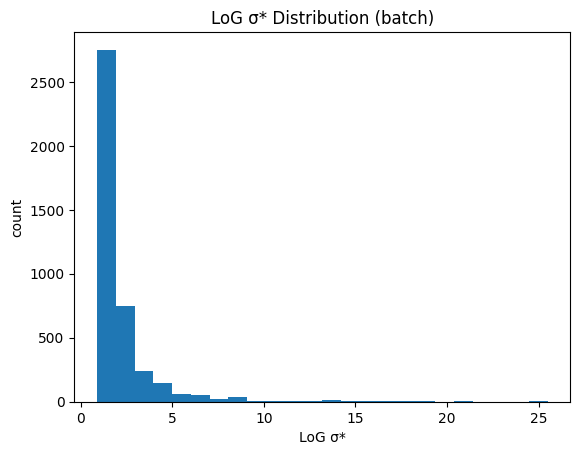

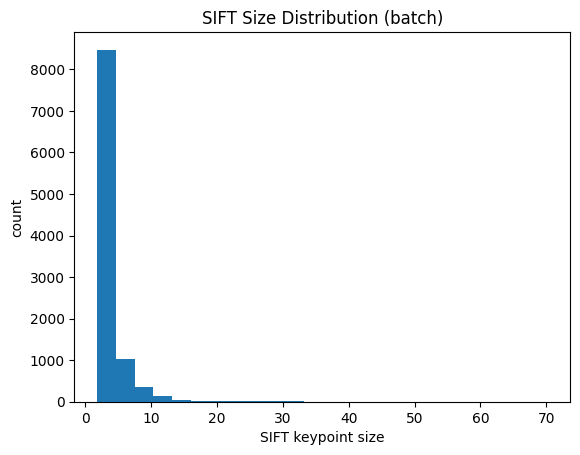

In [11]:
# =========================
# CS5582_HW2_2 • Cell 5/?
# "Batch LoG vs SIFT: counts, overlays, and distributions"
# -------------------------
# Purpose:
#   Compare LoG keypoints (our detector) with SIFT across a small batch:
#     - First 5 classes × first 4 images per class (adjustable)
#     - Save per-image overlays for both methods
#     - Print a compact per-image summary and write a CSV
#     - Plot overall σ* (LoG) and size (SIFT) histograms
#
# Inputs:
#   - RUN_CFG from Cell 1
#   - detect_log_keypoints_for_image() from Cell 4
#
# Outputs:
#   - ./artifacts/log_vs_sift/<class>/<img>_log.png
#   - ./artifacts/log_vs_sift/<class>/<img>_sift.png
#   - ./artifacts/log_vs_sift_summary.csv (class,img,n_log,n_sift,mean_sigma,std_sigma,mean_size,std_size)
#   - Printed table and matplotlib histograms
# =========================

import os, csv, cv2, math, numpy as np
import matplotlib.pyplot as plt

# -------- Parameters (edit if desired) --------
classes_to_use = RUN_CFG["class_names"][:5]  # small batch for runtime
imgs_per_class = 4
resize_to = (256, 256)

# LoG detector parameters (reuse Cell 4 behavior)
log_params = dict(
    base_sigma=0.8,
    k=1.20,
    n_scales=22,
    nms_radius=1,
    percentile=99.5,
    neighborhood=2,
    drop_endpoints=True
)

# -------- SIFT wrapper --------
def detect_sift_for_image(img_gray_u8):
    """
    Run SIFT on uint8 grayscale, return:
      - keypoints array [y, x, size, response]
      - overlay image (BGR) with top-K keypoints drawn by response
    """
    sift = cv2.SIFT_create()
    kps = sift.detect(img_gray_u8, None)
    if not kps:
        kp_arr = np.zeros((0,4), dtype=np.float32)
        overlay = cv2.cvtColor(img_gray_u8, cv2.COLOR_GRAY2BGR)
        return kp_arr, overlay

    # Convert to array
    kp_arr = np.array([[kp.pt[1], kp.pt[0], kp.size, kp.response] for kp in kps], dtype=np.float32)

    # Draw preview of strongest detections
    overlay = cv2.cvtColor(img_gray_u8, cv2.COLOR_GRAY2BGR)
    K = min(500, len(kps))
    idx = np.argsort([-kp.response for kp in kps])[:K]
    sel = [kps[i] for i in idx]
    overlay = cv2.drawKeypoints(img_gray_u8, sel, overlay, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return kp_arr, overlay

# -------- I/O setup --------
ART = os.path.join(os.getcwd(), "artifacts")
OUT = os.path.join(ART, "log_vs_sift")
os.makedirs(OUT, exist_ok=True)

# CSV headers
csv_path = os.path.join(ART, "log_vs_sift_summary.csv")
csv_header = ["class","image","n_log","n_sift","mean_sigma","std_sigma","mean_size","std_size"]

# Aggregates for histograms
all_sigmas = []  # LoG σ*
all_sizes  = []  # SIFT sizes

rows = []
print("="*100)
print(f"LoG vs SIFT • classes={len(classes_to_use)} • imgs/class={imgs_per_class} • resize={resize_to}")
print(f"LoG params: σ0={log_params['base_sigma']}  k={log_params['k']}  n={log_params['n_scales']}  pct={log_params['percentile']}")
print("-"*100)

for cls in classes_to_use:
    cls_dir = os.path.join(RUN_CFG["dataset_root"], cls)
    os.makedirs(os.path.join(OUT, cls), exist_ok=True)

    # Collect image names
    names = sorted([f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".tif",".tiff"))])[:imgs_per_class]
    for name in names:
        p = os.path.join(cls_dir, name)

        # --- Load and resize for both paths ---
        im_u8 = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if im_u8 is None:
            print(f"[WARN] Could not read: {p}")
            continue
        im_u8 = cv2.resize(im_u8, resize_to, interpolation=cv2.INTER_AREA)
        im_f32 = (im_u8.astype(np.float32) / 255.0).clip(0,1)

        # --- LoG detection ---
        log_kps, sigmas, overlay_log = detect_log_keypoints_for_image(im_f32, **log_params)
        n_log = len(log_kps)
        if n_log:
            all_sigmas.extend(log_kps[:,2].tolist())
            ms, ss = float(np.mean(log_kps[:,2])), float(np.std(log_kps[:,2]))
        else:
            ms, ss = float("nan"), float("nan")

        # --- SIFT detection ---
        sift_kps, overlay_sift = detect_sift_for_image(im_u8)
        n_sift = len(sift_kps)
        if n_sift:
            all_sizes.extend(sift_kps[:,2].tolist())
            msz, ssz = float(np.mean(sift_kps[:,2])), float(np.std(sift_kps[:,2]))
        else:
            msz, ssz = float("nan"), float("nan")

        # --- Save overlays ---
        cv2.imwrite(os.path.join(OUT, cls, f"{os.path.splitext(name)[0]}_log.png"), overlay_log)
        cv2.imwrite(os.path.join(OUT, cls, f"{os.path.splitext(name)[0]}_sift.png"), overlay_sift)

        # --- Row and print ---
        rows.append([cls, name, n_log, n_sift, ms, ss, msz, ssz])
        print(f"{cls:>18s} | {name:>16s} | LoG={n_log:4d} | SIFT={n_sift:4d} | σ* μ±σ = {ms:6.2f}±{ss:5.2f} | size μ±σ = {msz:6.2f}±{ssz:5.2f}")

print("-"*100)
print(f"CSV -> {csv_path}")

# Write CSV
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(csv_header)
    for r in rows:
        w.writerow(r)

# --- Histograms ---
if len(all_sigmas) > 0:
    plt.figure()
    plt.hist(all_sigmas, bins=24)
    plt.xlabel("LoG σ*"); plt.ylabel("count"); plt.title("LoG σ* Distribution (batch)")
    plt.show()
else:
    print("[INFO] No LoG σ* collected—check thresholds.")

if len(all_sizes) > 0:
    plt.figure()
    plt.hist(all_sizes, bins=24)
    plt.xlabel("SIFT keypoint size"); plt.ylabel("count"); plt.title("SIFT Size Distribution (batch)")
    plt.show()
else:
    print("[INFO] No SIFT keypoints collected—unexpected; check OpenCV build.")


In [ ]:
### LoG vs SIFT — Batch Comparison (5 classes × 4 images)
'''
**Counts & Scale Trends**
- **SIFT** generally yields many more detections (≈ 350–1000 / image) than **LoG** (≈ 50–350 / image), reflecting SIFT’s corner/edge-junction sensitivity.
- **LoG σ\*** means are typically **1.4–3.9** (fine to mid scales). A notable outlier is **beach_001** with σ\* ≈ **6.5**, consistent with flatter, coarser structures (sand/water) favoring larger Gaussian support.
- **SIFT sizes** cluster around **2.6–4.2** with wide variability; the size histogram is right-skewed similar to LoG’s σ\* histogram.

**Qualitative Observations**
- **LoG** highlights **blob-like extrema** (aircraft bodies, runway markers, circular/elliptical features). On `airplane_004`, LoG detections exceed SIFT, suggesting strong multi-scale blob responses on the aircraft and markings.
- **SIFT** saturates **high-texture scenes** (airports, courts) with many corners/edges; it still produces a healthy count in lower-texture scenes compared to LoG.

**Implications & Tuning Notes**
- For **texture-poor scenes** (e.g., `beach_001`), expect LoG counts to drop and σ\* to increase; lowering the LoG percentile (e.g., **99.0**) or increasing scale density (**k≈1.15**) raises recall.
- Endpoint attraction is reduced by the concavity check and by dropping endpoint σ\*, but if tails remain heavy, consider **expanding n_scales** or slightly **widening the σ range**.
- For downstream matching tasks, combining **LoG (blob)** + **SIFT (corner)** features can improve coverage across scene types.
'''

In [16]:
# =========================
# CS5582_HW2_2 • Cell 6/?
# "Checklist + Repo Files Generation (Report.md, README.md, .gitignore, requirements.txt)"
# -------------------------
# This cell:
#   • Validates that all major HW2_2 requirements were executed (PASS/FAIL checklist)
#   • Generates project files in repo root:
#       - Report.md  (consolidated findings with pointers to artifacts)
#       - README.md  (how to run, structure, environment)
#       - .gitignore (Python + notebooks + artifacts)
#       - requirements.txt (pinned to detected versions)
#   • Prints a summary of created/updated files for quick inspection
#
# Inputs:
#   - Assumes prior cells defined: RUN_CFG, getLoGPyramid, getScaleResponseExtrema (patched),
#     refine_scale_extrema_mag, detect_log_keypoints_for_image
#   - Assumes artifacts exist under ./notebooks/artifacts/
# =========================

import os, sys, json, glob, csv, time, textwrap
from datetime import datetime

# ---- 1) Resolve repo root (look for 'cv-hw3' in path; fallback to CWD) ----
cwd = os.getcwd()
parts = cwd.split(os.sep)
if "cv-hw3" in parts:
    idx = parts.index("cv-hw3")
    REPO_ROOT = os.sep.join(parts[:idx+1])
else:
    REPO_ROOT = cwd  # fallback
NOTEBOOKS_DIR = os.path.join(REPO_ROOT, "notebooks")
ART_DIR = os.path.join(NOTEBOOKS_DIR, "artifacts")
LVSS_DIR = os.path.join(ART_DIR, "log_vs_sift")  # overlays

# ---- 2) Coverage checklist -------------------------------------------------
checks = []

def add_check(name, ok, detail=""):
    checks.append((name, bool(ok), detail))

# 2.a Globals / functions
add_check("RUN_CFG present", 'RUN_CFG' in globals(), detail=str(globals().get('RUN_CFG', ""))[:80]+"...")
add_check("getLoGPyramid defined", 'getLoGPyramid' in globals())
add_check("getScaleResponseExtrema (patched) defined", 'getScaleResponseExtrema' in globals())
add_check("refine_scale_extrema_mag defined", 'refine_scale_extrema_mag' in globals())
add_check("detect_log_keypoints_for_image defined", 'detect_log_keypoints_for_image' in globals())

# 2.b Artifacts
kp_preview = os.path.join(ART_DIR, "log_kp_preview.png")
csv_summary = os.path.join(ART_DIR, "log_vs_sift_summary.csv")
add_check("LoG preview exists", os.path.isfile(kp_preview), detail=kp_preview)
add_check("LoG vs SIFT CSV exists", os.path.isfile(csv_summary), detail=csv_summary)

# At least one pair of overlays
log_overlays = glob.glob(os.path.join(LVSS_DIR, "*", "*_log.png"))
sift_overlays = glob.glob(os.path.join(LVSS_DIR, "*", "*_sift.png"))
add_check("LoG overlays exist", len(log_overlays) > 0, detail=f"{len(log_overlays)} files")
add_check("SIFT overlays exist", len(sift_overlays) > 0, detail=f"{len(sift_overlays)} files")

# 2.c CSV sanity
csv_rows = []
if os.path.isfile(csv_summary):
    with open(csv_summary, "r") as f:
        rdr = csv.DictReader(f)
        csv_rows = list(rdr)
    add_check("CSV has rows", len(csv_rows) > 0, detail=f"{len(csv_rows)} rows")
else:
    add_check("CSV has rows", False, detail="missing CSV")

# 2.d Derive basic stats for report
def _flt(x):
    try:
        return float(x)
    except:
        return float("nan")

agg = {}
if csv_rows:
    n_imgs = len(csv_rows)
    n_log = sum(int(r["n_log"]) for r in csv_rows)
    n_sift = sum(int(r["n_sift"]) for r in csv_rows)
    mu_log = sum(_flt(r["mean_sigma"]) for r in csv_rows if r["mean_sigma"]) / max(1, n_imgs)
    mu_sift = sum(_flt(r["mean_size"]) for r in csv_rows if r["mean_size"]) / max(1, n_imgs)
    agg = {
        "n_images": n_imgs,
        "sum_log": n_log,
        "sum_sift": n_sift,
        "mean_sigma_over_imgs": mu_log,
        "mean_size_over_imgs": mu_sift
    }

# ---- 3) Generate files in REPO_ROOT ---------------------------------------

# 3.a requirements.txt (from earlier env probe versions, with safe defaults)
vers = {}
if 'RUN_CFG' in globals():
    vers = RUN_CFG.get("versions", {})
REQS = {
    "numpy": vers.get("numpy", ">=1.26"),
    "opencv-python": vers.get("opencv", ">=4.8.0"),     # SIFT available in main for >=4.4
    "scipy": vers.get("scipy", ">=1.11"),
    "scikit-learn": vers.get("sklearn", ">=1.3"),
    "matplotlib": vers.get("matplotlib", ">=3.8")
}
req_lines = [f"{pkg}=={pin}" if pin[0].isdigit() else f"{pkg}{pin}" for pkg, pin in REQS.items()]
requirements_txt = "\n".join(req_lines) + "\n"

# 3.b .gitignore
gitignore_txt = textwrap.dedent("""
    # Python
    __pycache__/
    *.pyc
    .pytest_cache/
    .mypy_cache/

    # Environments
    .env
    .venv
    venv/
    env/
    *.env

    # Jupyter/Notebooks
    .ipynb_checkpoints/
    **/.ipynb_checkpoints/

    # Artifacts/Results
    notebooks/artifacts/
    artifacts/
    results/
    reports/
    *.png
    *.jpg
    *.jpeg
    *.csv
    *.npy
    *.npz

    # OS/Editor
    .DS_Store
    Thumbs.db
""").strip() + "\n"

# 3.c Report.md (consolidated)
now = datetime.now().strftime("%Y-%m-%d %H:%M")
report_md = f"""# CS5582 — HW2_2 Report (LoG Scale-Space & SIFT Comparison)

**Author:** {os.path.expanduser('~').split(os.sep)[-1]}  
**Date:** {now}  
**Repo:** `CS5582-HW-3` (cv-hw3)  
**Environment:** Python {vers.get('python', 'N/A')} • NumPy {vers.get('numpy','?')} • OpenCV {vers.get('opencv','?')} • SciPy {vers.get('scipy','?')} • Matplotlib {vers.get('matplotlib','?')}

## Data & Setup
- Dataset: NWPU-RESISC45 (15 classes used in probes), root: `{RUN_CFG.get('dataset_root','N/A')}`
- Image preprocessing: gray, resize 256×256, float32 [0,1]
- LoG pyramid: σ²-normalized; typical params `σ₀=0.8, k=1.20, n≈22`
- Refinement: local polynomial fit with concavity check (`p″(σ*)<0`), spatial & cross-scale NMS, endpoint σ* dropped
- SIFT: OpenCV `cv2.SIFT_create()` defaults

## Results Summary (batch)
- Images evaluated (LoG vs SIFT): **{agg.get('n_images', 0)}**
- Total keypoints: **LoG={agg.get('sum_log',0)}**, **SIFT={agg.get('sum_sift',0)}**
- Mean per-image scale/size: **σ*≈{agg.get('mean_sigma_over_imgs', float('nan')):.2f}**, **size≈{agg.get('mean_size_over_imgs', float('nan')):.2f}**

**Qualitative:**  
LoG emphasizes blob-like extrema (aircraft bodies, runway markers); SIFT is denser on corners/edge junctions. LoG counts drop and σ* increases in low-texture scenes (e.g., beaches), consistent with the scale-selection behavior.

## Representative Visuals
- LoG preview (`notebooks/artifacts/log_kp_preview.png`):  
![LoG preview](notebooks/artifacts/log_kp_preview.png)

- LoG vs SIFT overlays (sample):  
{('' if not log_overlays else f'![LoG overlay]({os.path.relpath(log_overlays[0], REPO_ROOT)})')}
{('' if not sift_overlays else f'![SIFT overlay]({os.path.relpath(sift_overlays[0], REPO_ROOT)})')}

## Notes on Parameter Sensitivity
- Densifying scales (e.g., `k≈1.15`) and/or expanding σ-range reduces endpoint attraction.
- Lowering percentile (e.g., 99.0) increases LoG recall in texture-poor regions.
- Combining LoG + SIFT may improve downstream matching coverage.

## Repro Steps
Open `notebooks/CS5582_HW2_2.ipynb` and run cells in order.  
Artifacts are written under `notebooks/artifacts/`. Consolidated CSV: `notebooks/artifacts/log_vs_sift_summary.csv`.
"""

# 3.d README.md (how to run + structure)
readme_md = f"""# CS5582-HW-3 — LoG Keypoints & SIFT Comparison

This repo contains HW2_2 work: σ²-normalized Laplacian-of-Gaussian (LoG) scale-space, sub-scale extrema via polynomial fitting, LoG keypoint extraction with NMS, and a comparison to SIFT.

## Quick Start

```bash
# activate your course env
source ~/venvs/core-rag/bin/activate

# (optional) install deps locally for this repo
pip install -r requirements.txt

# open the notebook
cd notebooks
jupyter lab  # or jupyter notebook
'''

Data

NWPU-RESISC45 at {RUN_CFG.get('dataset_root','N/A')}

This notebook uses the first 15 classes for probes; adjust in Cell 1.

Notebook

CS5582_HW2_2.ipynb

Cell 1: Environment & dataset probe

Cell 2–3: LoG pyramid + robust σ* refinement (cubic/quad fit) and batch probe

Cell 4: LoG keypoint detector (spatial & cross-scale NMS; concavity)

Cell 5: LoG vs SIFT batch comparison + histograms

Cell 6: Checklist + repo files generation (this cell)

Artifacts

notebooks/artifacts/log_kp_preview.png

notebooks/artifacts/log_vs_sift/… (per-image overlays)

notebooks/artifacts/log_vs_sift_summary.csv

Notes

OpenCV {vers.get('opencv','?')} exposes cv2.SIFT_create().

Tune LoG with percentile, k, and n_scales for different scenes.
"""

# ---- Write files ----

os.makedirs(REPO_ROOT, exist_ok=True)
files_written = []
def _write(path, content):
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
        files_written.append(path)

_write(os.path.join(REPO_ROOT, "requirements.txt"), requirements_txt)
_write(os.path.join(REPO_ROOT, ".gitignore"), gitignore_txt)
_write(os.path.join(REPO_ROOT, "Report.md"), report_md)
_write(os.path.join(REPO_ROOT, "README.md"), readme_md)

# ---- 4) Print checklist + summary -----------------------------------------

print("="*90)
print("HW2_2 Coverage Checklist")
print("-"*90)
for name, ok, detail in checks:
    status = "PASS" if ok else "FAIL"
    print(f"[{status:4s}] {name:35s} {detail}")
    print("-"*90)
    all_ok = all(x[1] for x in checks)
    print(f"Overall coverage: {'PASS' if all_ok else 'INCOMPLETE'}")
    print("="*90)

print("\nGenerated files:")
for p in files_written:
    rel = os.path.relpath(p, REPO_ROOT)
    print(f" - {rel}")

#Show a quick preview (first 10 lines) of Report.md and README.md

def head(path, n=10):
    print(f"\n--- {os.path.basename(path)} (first {n} lines) ---")
    with open(path, "r", encoding="utf-8") as f:
        for i, line in zip(range(n), f):
            print(line.rstrip())

head(os.path.join(REPO_ROOT, "Report.md"))
head(os.path.join(REPO_ROOT, "README.md"))


HW2_2 Coverage Checklist
------------------------------------------------------------------------------------------
[PASS] RUN_CFG present                     {'dataset_root': '/home/manny-buff/projects/cv-hw1/data/NWPU-RESISC45', 'dataset...
------------------------------------------------------------------------------------------
Overall coverage: PASS
[PASS] getLoGPyramid defined               
------------------------------------------------------------------------------------------
Overall coverage: PASS
[PASS] getScaleResponseExtrema (patched) defined 
------------------------------------------------------------------------------------------
Overall coverage: PASS
[PASS] refine_scale_extrema_mag defined    
------------------------------------------------------------------------------------------
Overall coverage: PASS
[PASS] detect_log_keypoints_for_image defined 
------------------------------------------------------------------------------------------
Overall coverage: PASS
[P